# Predictive Analytics for Enhancing Customer Purchase Intentions in E-Commerce

### Team : Big Data Avengers

Team members : Gopi Chand Yenikapalli , Kushal Reddy Rededdy, Manoj Arasada, Manasa Swetha Tiramareddy

# Business Challenge:
### Our e-commerce business faces a challenge with declining customer engagement, increasing bounce rates, and decreasing revenue. To reverse this trend, we need to understand customer behavior, and make data-driven changes to boost revenue. This involves identifying pain points, optimizing design and content, and using predictive models for competitive positioning in the e-commerce market.

# Problem Statement:

### The e-commerce industry has witnessed a significant shift in consumer behavior, with a growing preference for online shopping. In light of this trend, businesses are seeking to leverage data analytics to gain a competitive edge. Our e-commerce business is currently facing challenges characterized by declining customer engagement, increasing bounce rates, and consequently, diminishing revenues.

### To address these issues, it is imperative to delve deeper into the online shopper's journey, analyzing their browsing and purchasing patterns. A predictive model is required to ascertain the intent of shoppers to make a purchase. This model will enable us to discern the likelihood of a customer completing a transaction based on their interaction with our online platform.

### The objective is to utilize a comprehensive dataset that encapsulates the core aspects of the online shopping experience. By examining variables such as session duration, page views, cart bounce rate, and other relevant metrics, we aim to develop a robust predictive framework. This framework will not only forecast purchasing intentions but also inform targeted interventions to enhance the customer experience.

# Data Source:
### The data is sourced from the UCI Machine Learning Repository, which can be found here: [Online Shoppers Purchasing Intention Dataset](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset).

# Dataset Overview:
### The dataset captures the essence of online shopping, a significant segment of the B2C (Business to Customer) market. Understanding the patterns of online shoppers in terms of their research and purchasing habits is vital for businesses. Insights into these behaviors can guide targeted marketing strategies and promotional activities to enhance sales and overall revenue.

# 1. Importing the Data

In [1]:
# Importing required packages
from pyspark.sql import SparkSession;
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType
from pyspark.ml.feature import VectorAssembler,StringIndexer ,OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
import pandas as pd
from pyspark.context import SparkContext
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


In [2]:
# warehouse_location points to the default location for managed databases and tables
from os.path import abspath
warehouse_location = abspath('spark-warehouse')

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("ISM6562 PySpark Tutorials") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()


# Let's get the SparkContext object. It's the entry point to the Spark API. It's created when you create a sparksession
sc = spark.sparkContext
sc.setLogLevel("ERROR") # only display errors (not warnings

# note: If you have multiple spark sessions running (like from a previous notebook you've run), 
# this spark session webUI will be on a different port than the default (4040). One way to 
# identify this part is with the following line. If there was only one spark session running, 
# this will be 4040. If it's higher, it means there are still other spark sesssions still running.
spark_session_port = spark.sparkContext.uiWebUrl.split(":")[-1]
print("Spark Session WebUI Port: " + spark_session_port)

23/11/07 17:53:02 WARN Utils: Your hostname, localhost.localdomain resolves to a loopback address: 127.0.0.1; using 10.21.11.148 instead (on interface eth0)
23/11/07 17:53:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/07 17:53:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session WebUI Port: 4040


In [3]:
spark

In [4]:
# Load data using spark
df = spark.read.csv('data/online_shoppers_intention.csv', header = True, inferSchema= True)
df.show(5)

+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+---------+----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+
|Administrative|Administrative_Duration|Informational|Informational_Duration|ProductRelated|ProductRelated_Duration|BounceRates|ExitRates|PageValues|SpecialDay|Month|OperatingSystems|Browser|Region|TrafficType|      VisitorType|Weekend|Revenue|
+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+---------+----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+
|             0|                    0.0|            0|                   0.0|             1|                    0.0|        0.2|      0.2|       0.0|       0.0|  Feb|               1|      1|     1|          1|Returning_Visitor|  false|      0|
|             0|    

# 2. Data Exploration and Preprocessing

In [5]:
# print imported data schema
df.printSchema()

root
 |-- Administrative: integer (nullable = true)
 |-- Administrative_Duration: double (nullable = true)
 |-- Informational: integer (nullable = true)
 |-- Informational_Duration: double (nullable = true)
 |-- ProductRelated: integer (nullable = true)
 |-- ProductRelated_Duration: double (nullable = true)
 |-- BounceRates: double (nullable = true)
 |-- ExitRates: double (nullable = true)
 |-- PageValues: double (nullable = true)
 |-- SpecialDay: double (nullable = true)
 |-- Month: string (nullable = true)
 |-- OperatingSystems: integer (nullable = true)
 |-- Browser: integer (nullable = true)
 |-- Region: integer (nullable = true)
 |-- TrafficType: integer (nullable = true)
 |-- VisitorType: string (nullable = true)
 |-- Weekend: boolean (nullable = true)
 |-- Revenue: integer (nullable = true)



In [6]:
# Exploring number of rows and columns
rows = df.count()
cols = len(df.columns)
print(f"Rows={rows} and Cols={cols}")

Rows=12330 and Cols=18


In [7]:
#see the column name
column_names = df.columns
print(column_names)

['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']


### Column Descriptions:

Administrative: The number of pages of administrative information visited by the user.

Administrative_Duration: The total time spent by the user on the administrative pages.

Informational: The number of pages of informational content visited by the user.

Informational_Duration: The total time spent by the user on the informational pages.

ProductRelated: The number of pages of product-related content visited by the user.

ProductRelated_Duration: The total time spent by the user on the product-related pages.

BounceRates: The percentage of visitors who enter the website and leave without viewing any other pages.

ExitRates: The percentage of visitors who leave the website after viewing a page.

PageValues: The average value of the pages viewed by the user before the purchase.

SpecialDay: The closeness of the visit to a special day like Mother's Day or Valentine's Day.

Month: The month of the year when the user visited the website.

OperatingSystem: The operating system used by the user.

Browser: The browser used by the user.

Region: The geographical region of the user.

TrafficType: The type of traffic source from which the user arrived at the website.

VisitorType: The type of visitor - returning or new.

Weekend: A binary value indicating whether the visit occurred on a weekend or not.

Revenue: The target variable indicating whether the user made a purchase or not (1 for purchase, 0 for no purchase).

In [8]:
# check for if there is any missing values in remaining columns
# Counting nulls in each column

null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

# Show the result
null_counts.show()

+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+---------+----------+----------+-----+----------------+-------+------+-----------+-----------+-------+-------+
|Administrative|Administrative_Duration|Informational|Informational_Duration|ProductRelated|ProductRelated_Duration|BounceRates|ExitRates|PageValues|SpecialDay|Month|OperatingSystems|Browser|Region|TrafficType|VisitorType|Weekend|Revenue|
+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+---------+----------+----------+-----+----------------+-------+------+-----------+-----------+-------+-------+
|             0|                      0|            0|                     0|             0|                      0|          0|        0|         0|         0|    0|               0|      0|     0|          0|          0|      0|      0|
+--------------+-----------------------+----

Here we can see that there are no null values in the dataset. We do not need to fix or replace any null values in the dataset.

In [9]:
# Count the target variable how many 1 and 0 .
revenue_count = df.groupBy('REVENUE').count()

# Show the result
revenue_count.show()

+-------+-----+
|REVENUE|count|
+-------+-----+
|      1| 1908|
|      0|10422|
+-------+-----+



The target variable 'Revenue' is a binary variable that indicates whether a customer completed a transaction or not. As we see that, the majority(10,422) of the entries in the dataset have a value of 0 for the 'Revenue' column, indicating that the customer did not make a purchase. This is expected in the context of e-commerce, where a large number of visitors may browse through the website but only a small percentage may actually make a purchase.

# 3. Create a SQL table

In [10]:
# Drop table if exist and create new table named customer_purchase_intention
spark.sql('drop table if exists customer_purchase_intention')
df.write.saveAsTable('customer_purchase_intention')

In [11]:
#show existing namespaces  
df_sql=spark.sql("show databases")
df_sql.show()

+---------+
|namespace|
+---------+
|  default|
|   w10_db|
+---------+



In [12]:
# List the Spark datawarehouse. It should show the default database.
spark.catalog.listTables()

[Table(name='customer_purchase_intention', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False)]

In [13]:
# List the tables in the database.
spark.sql("show tables").show()

+---------+--------------------+-----------+
|namespace|           tableName|isTemporary|
+---------+--------------------+-----------+
|  default|customer_purchase...|      false|
+---------+--------------------+-----------+



# 4. Data Exploration using Pyspark SQL and Visulizations using pandas

+-----+-----+
|MONTH|count|
+-----+-----+
|  May| 3364|
|  Nov| 2998|
|  Mar| 1907|
|  Dec| 1727|
|  Oct|  549|
|  Sep|  448|
|  Aug|  433|
|  Jul|  432|
| June|  288|
|  Feb|  184|
+-----+-----+



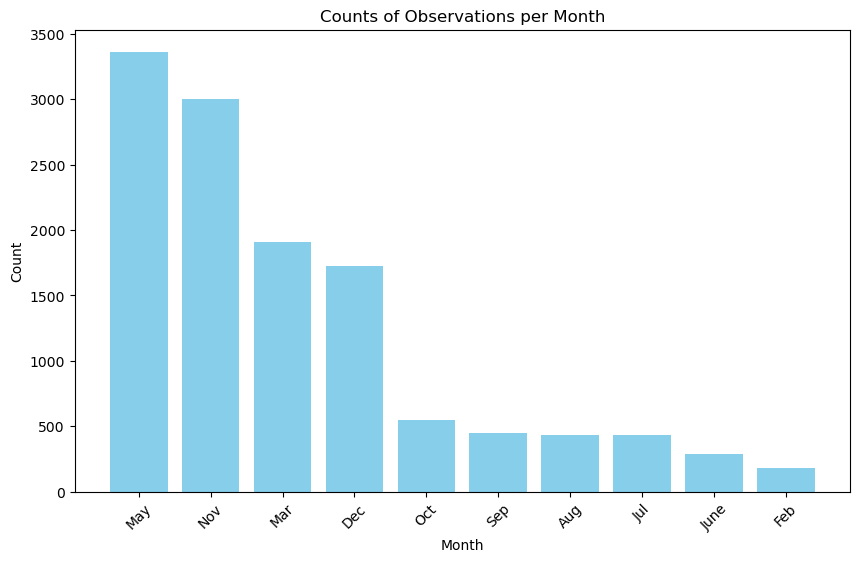

In [14]:
# Explore the distribution of monthly entires
query_result = spark.sql("""
SELECT MONTH, COUNT(*) AS count
FROM customer_purchase_intention
GROUP BY MONTH
ORDER BY count DESC
""")
query_result.show()

# Collect the data into a Pandas DataFrame
monthly_counts_pd = query_result.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(monthly_counts_pd['MONTH'], monthly_counts_pd['count'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Counts of Observations per Month')
plt.xticks(rotation=45)  # Rotate the x labels to make them readable
plt.show()

We can see here that the 'MONTH' column is missing January and April months

The 'MONTH' column in the dataset will be removed due to its limited variability with only 10 unique months represented, indicating that data for two months is missing. The unequal distribution of data across the months could introduce bias in month-based classification. Additionally, the 'SpecialDay' column captures time-sensitive information relevant to purchasing behavior, making 'MONTH' somewhat redundant. The presence of disproportionately high samples in certain months (like May and November) compared to significantly lower samples in others (such as February and June) further supports the decision to exclude 'MONTH' from further analysis to prevent potential biases.

+----------------+-----+
|OPERATINGSYSTEMS|count|
+----------------+-----+
|               2| 6601|
|               1| 2585|
|               3| 2555|
|               4|  478|
|               8|   79|
|               6|   19|
|               7|    7|
|               5|    6|
+----------------+-----+



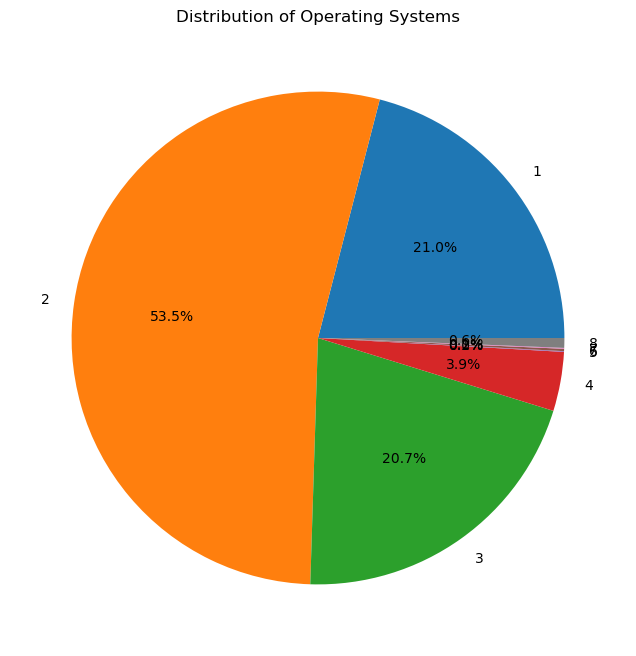

In [15]:
# Explore the distribution of Operating System
query_result = spark.sql("""
SELECT OPERATINGSYSTEMS, COUNT(*) AS count
FROM customer_purchase_intention
GROUP BY OPERATINGSYSTEMS
ORDER BY count DESC
""")
query_result.show()

# Collect the data into a Pandas DataFrame
os_count_pd = query_result.toPandas().set_index('OPERATINGSYSTEMS')

# Sort the DataFrame by index (Operating System) for better visualization
os_count_pd.sort_index(inplace=True)

# Plotting using Matplotlib
plt.figure(figsize=(8, 8))
plt.pie(os_count_pd['count'], labels=os_count_pd.index, autopct='%1.1f%%')
plt.title("Distribution of Operating Systems")
plt.show()

The "OperatingSystems" column, which is numerically labeled from 1 to 8, shows a predominant use of operating system 2, while operating system 5 is scarcely used. Given its limited impact on the predictive model's performance, this column will be dropped from the dataset.

+-------+-----+
|BROWSER|count|
+-------+-----+
|      2| 7961|
|      1| 2462|
|      4|  736|
|      5|  467|
|      6|  174|
|     10|  163|
|      8|  135|
|      3|  105|
|     13|   61|
|      7|   49|
|     12|   10|
|     11|    6|
|      9|    1|
+-------+-----+



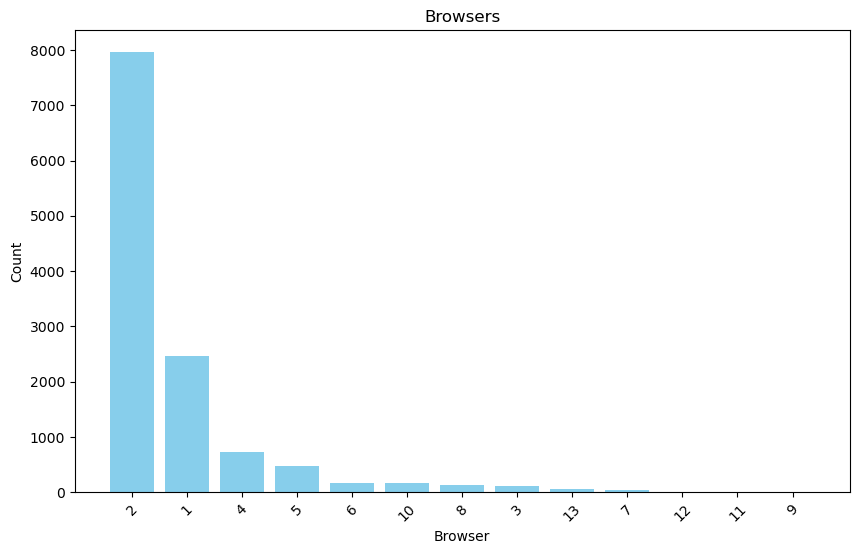

In [16]:
# #Exploring the disctribution of Browser
browser_counts = spark.sql("""
SELECT BROWSER, COUNT(*) AS count
FROM customer_purchase_intention
GROUP BY BROWSER
ORDER BY count DESC
""")
browser_counts.show()

# Collect the data into a Pandas DataFrame
browser_counts_pd = browser_counts.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(browser_counts_pd['BROWSER'].astype(str), browser_counts_pd['count'], color='skyblue')
plt.title('Browsers')
plt.xlabel('Browser')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


The majority of users utilize browsers 1 and 2, while other browsers have significantly fewer users. Given this skewed distribution and the negligible contribution of the browser type to the predictive power of our model, the 'BROWSER' column will be excluded from further analysis.

+-----------+-----+
|TRAFFICTYPE|count|
+-----------+-----+
|          2| 3913|
|          1| 2451|
|          3| 2052|
|          4| 1069|
|         13|  738|
|         10|  450|
|          6|  444|
|          8|  343|
|          5|  260|
|         11|  247|
|         20|  198|
|          9|   42|
|          7|   40|
|         15|   38|
|         19|   17|
|         14|   13|
|         18|   10|
|         16|    3|
|         12|    1|
|         17|    1|
+-----------+-----+



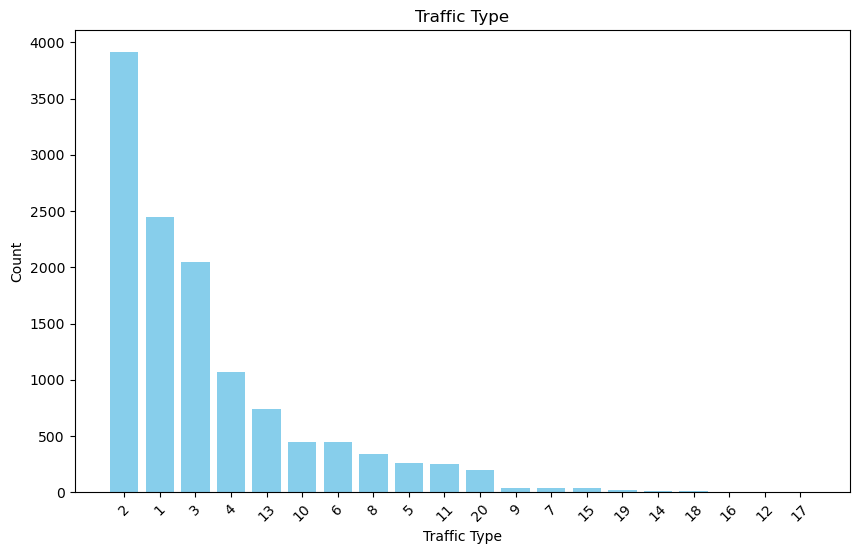

In [17]:
#Exploring the distribution of TrafficeType
traffic_type_counts = spark.sql("""
SELECT TRAFFICTYPE, COUNT(*) AS count
FROM customer_purchase_intention
GROUP BY TRAFFICTYPE
ORDER BY count DESC
""")
traffic_type_counts.show()
# Collect the data into a Pandas DataFrame
traffic_type_counts_pd = traffic_type_counts.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(traffic_type_counts_pd['TRAFFICTYPE'].astype(str), traffic_type_counts_pd['count'], color='skyblue')
plt.title('Traffic Type')
plt.xlabel('Traffic Type')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate the x labels to make them readable
plt.show()

The "TrafficType" column will be omitted from the predictive modeling as its relevance to purchase likelihood appears limited. Although it offers insights into the origins of web traffic, which is valuable for marketing and advertising strategies, it does not substantially inform on the purchasing tendencies of visitors. Therefore, the focus will be on more direct indicators of user behavior and purchase intent.

+-------+-----+
|WEEKEND|count|
+-------+-----+
|   true| 2868|
|  false| 9462|
+-------+-----+



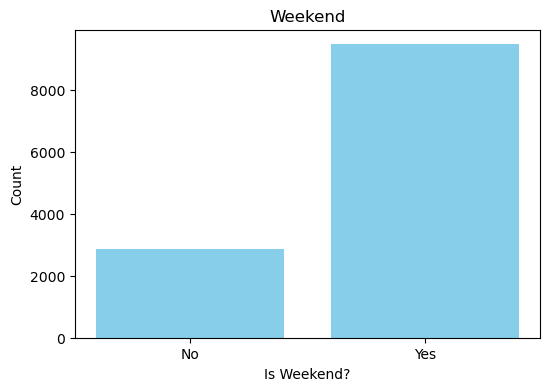

In [18]:
#Exploring the distribution of Weekend purchases
weekend_counts = spark.sql("""
SELECT WEEKEND, COUNT(*) AS count
FROM customer_purchase_intention
GROUP BY WEEKEND
""")
weekend_counts.show()

# Collect the data into a Pandas DataFrame
weekend_counts_pd = weekend_counts.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(6, 4))
plt.bar(weekend_counts_pd['WEEKEND'].astype(str), weekend_counts_pd['count'], color='skyblue')
plt.title('Weekend')
plt.xlabel('Is Weekend?')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])  # Assuming the WEEKEND column is binary
plt.show()

As per the famous article, Best Day of The Week for Online Sales,SaleCycle data found Wednesday and Thursday saw the busiest retail days online for online sales with Saturday being the worst day of the week for online sales. However in most recent findings, Monday has taken the lion’s share of online sales for the last two years in a row. Sunday currently bodes the lowest amount of online sales.The weekend is certainly the quietest time for ecommerce activity, when people have more leisure time and therefore are less likely to be around a device on which they can shop.https://www.salecycle.com/wp-content/uploads/2023/01/coponline-sales-volume-by-day-2022-2-1.png. from the above bar chart we can say majority claas is not weekend.There is weak correlation between days of the week and online shopping. asserts that Sundays and Mondays have the highest traffic for eCommerce.so, dropping this column too.

+------+-----+
|REGION|count|
+------+-----+
|     1| 4780|
|     2| 1136|
|     3| 2403|
|     4| 1182|
|     5|  318|
|     6|  805|
|     7|  761|
|     8|  434|
|     9|  511|
+------+-----+



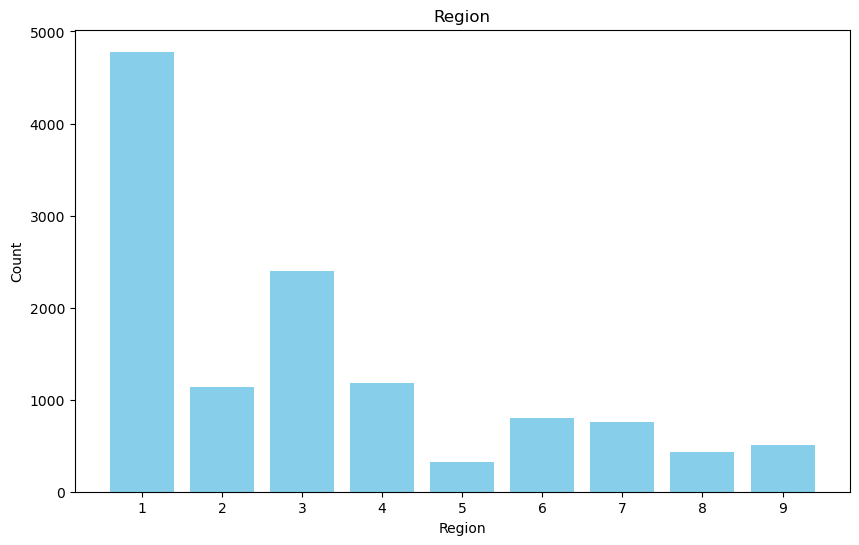

In [19]:
#Exploring the distribution of Region
region_counts = spark.sql("""
SELECT REGION, COUNT(*) AS count
FROM customer_purchase_intention
GROUP BY REGION
ORDER BY REGION
""")
region_counts.show()

# Collect the data into a Pandas DataFrame
region_counts_pd = region_counts.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(region_counts_pd['REGION'].astype(str), region_counts_pd['count'], color='skyblue')
plt.title('Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

The "Region" column will be omitted from the feature set as its impact on purchase probability is considered marginal. Eliminating this column simplifies the model and focuses on more influential factors in predicting visitor purchasing behavior.

# 5. Feature Engineering

As per the above assumptions and data distribution pattern, we are excluding those mentioned columns of Month, Specialday, Operatingsystems, Browser, Traffictype, Weekend, and Region for our prediction model.

In [20]:
df = df.drop('REGION', 'WEEKEND', 'TRAFFICTYPE', 'BROWSER', 'OPERATINGSYSTEMS', 'MONTH', 'SPECIALDAY')

In [21]:
df.columns

['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'VisitorType',
 'Revenue']

In [22]:
input_column = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated',
 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'VisitorType', 'Revenue']
train_df, test_df =df.randomSplit([0.7,0.3])
train_df = train_df.select(input_column)
test_df = test_df.select(input_column)
train_df.show(5)

+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+-----------+----------+-----------------+-------+
|Administrative|Administrative_Duration|Informational|Informational_Duration|ProductRelated|ProductRelated_Duration|BounceRates|  ExitRates|PageValues|      VisitorType|Revenue|
+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+-----------+----------+-----------------+-------+
|             0|                    0.0|            0|                   0.0|             0|                    0.0|       0.18|0.181818182|       0.0|Returning_Visitor|      0|
|             0|                    0.0|            0|                   0.0|             0|                    0.0|        0.2|        0.2|       0.0|Returning_Visitor|      0|
|             0|                    0.0|            0|                   0.0|             1|                  

## 5.1 Address any Data Imbalance

In [23]:
revenue_count = train_df.groupBy('REVENUE').count()

# Show the result
revenue_count.show()

+-------+-----+
|REVENUE|count|
+-------+-----+
|      1| 1355|
|      0| 7312|
+-------+-----+



In [24]:
# Checking for the data imbalance as per 10% rule
((7355-1340)/(1340+7355))*100 # this calculation based on initial split

69.17768832662449

 69%, it is greater than 10% so raw dataset is imbalanced

In [25]:
# Calculate the ratio to oversample the minority class
ratio = int(7355 / 1340)
print(ratio)

5


In [26]:
from pyspark.sql.functions import col, explode, array, lit, rand
# Separate majority and minority classes
major_df = train_df.filter(col('REVENUE') == 0)
minor_df = train_df.filter(col('REVENUE') == 1)

In [27]:
# Calculate the oversampling ratio
ratio = major_df.count() // minor_df.count()

In [28]:
# Oversample the minority class
# Create an array column with 'ratio' copies of the minority rows
oversampled_minor_df = minor_df.withColumn('oversample', explode(array([lit(x) for x in range(ratio)]))).drop('oversample')

# Combine the oversampled minority rows with the majority class
balanced_df = major_df.unionAll(oversampled_minor_df)

# Shuffle the DataFrame (optional but recommended)
balanced_df = balanced_df.orderBy(rand())

In [29]:
train_df =balanced_df

In [30]:
revenue_count = train_df.groupBy('REVENUE').count()

# Show the result
revenue_count.show()

+-------+-----+
|REVENUE|count|
+-------+-----+
|      0| 7312|
|      1| 6775|
+-------+-----+



In [31]:
#checking for data imbalance as per 10% rule
(7355-6700)/(7355+6700)*100

4.660263251511918

4.7% is less than 10% we can say now data set is balanced.

In [32]:
# Use StringIndexer to convert the categorical columns to hold numerical data
VisitorType_indexer = StringIndexer(inputCol = 'VisitorType' , outputCol = 'VisitorType_index' , handleInvalid = 'keep')

OneHotEncoderEstimator converts the indexed data into a vector which will be effectively handled

In [33]:
data_encoder = OneHotEncoder(
    inputCols=[
        'VisitorType_index'
    ], 
    outputCols= [
        'VisitorType_by_vec'],
    handleInvalid='keep'
)

Vector assembler is used to create a vector of input features

In [34]:
assembler = VectorAssembler(
    inputCols=['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'VisitorType_by_vec'],
    outputCol="unscaled_features"
)

In [35]:
# scaling values uisng standard scaler
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="unscaled_features",outputCol="features")

# 6. Evaluation metrics Identification

### In this context of predicting customer purchasing intentions where false negatives (failing to identify a potential purchaser) and false positives (wrongly identifying a visitor as a potential purchaser) may have different costs to the business.

Our aim to capture as many potential purchasers as possible because the cost of missing out on a purchaser is high, i.e recall and to ensure that the marketing efforts (like sending out promotional materials or coupons) are as efficient as possible and target only those who are very likely to purchase, (then precision is more important).

### For our objectives— Maximizing the capture of potential purchasers while ensuring efficient marketing efforts—we should focus on both recall and precision. Since both false positives and false negatives carry significant costs, the F1 score, which balances precision and recall, would be the most appropriate metric for evaluating our predictive model.

## F1 score

# 7. Machine Learning Models

# 7.1 LogisticRegression model

In [36]:
#Create an object for the Logistic Regression model
lr_model = LogisticRegression(labelCol='Revenue')

In [37]:
#Pipeline is used to pass the data through indexer and assembler simultaneously.
#Also, it helps to pre-rocess the test data in the same way as that of the train data. 
pipe = Pipeline(
    stages=[
        VisitorType_indexer,
        data_encoder,
        assembler,
        scaler,
        lr_model
    ]
)

In [38]:
# run the pipeline
fit_model=pipe.fit(train_df)

# Store the results in a dataframe
results = fit_model.transform(test_df)
results.select(['Revenue','prediction']).show(5)

+-------+----------+
|Revenue|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
+-------+----------+
only showing top 5 rows



# 7.1.1 Model Evaluation

In [39]:
# Create evaluators
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Revenue', metricName='areaUnderROC')
PR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Revenue', metricName='areaUnderPR')
evaluator = MulticlassClassificationEvaluator(labelCol="Revenue", predictionCol="prediction")

# Evaluate metrics
AUC = AUC_evaluator.evaluate(results)
PR = PR_evaluator.evaluate(results)
accuracy = evaluator.setMetricName("accuracy").evaluate(results)
recall = evaluator.setMetricName("recallByLabel").setMetricLabel(1).evaluate(results)  
precision = evaluator.setMetricName("precisionByLabel").setMetricLabel(0).evaluate(results)
f1_score = evaluator.setMetricName("f1").evaluate(results)

# Print results
print(f"The area under the AUC curve is {AUC}")
print(f"The area under the PR curve is {PR}")
print(f"The accuracy of the model is {accuracy}")
print(f"The recall of the model is {recall}")
print(f"The precision of the model is {precision}")
print(f"The f1_score of the model is {f1_score}")

The area under the AUC curve is 0.805716553380276
The area under the PR curve is 0.5038998440783342
The accuracy of the model is 0.8733278733278733
The recall of the model is 0.7088607594936709
The precision of the model is 0.9457547169811321
The f1_score of the model is 0.8790546633587107


# 7.2 DecisionTree Classification

In [40]:
# Creating an object for Decision Tree Classification
dt_model = DecisionTreeClassifier(labelCol='Revenue', maxBins=5000)

In [41]:
#Pipeline is used to pass the data through indexer and assembler simultaneously.
#Also, it helps to pre-rocess the test data in the same way as that of the train data.
pipe = Pipeline(
    stages=[
        VisitorType_indexer,
        data_encoder,
        assembler,
        scaler,
        dt_model
    ]
)

In [42]:
# run the pipeline
fit_model=pipe.fit(train_df)

# Store the results in a dataframe
results = fit_model.transform(test_df)
results.select(['Revenue','prediction']).show(5)

+-------+----------+
|Revenue|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
+-------+----------+
only showing top 5 rows



# 7.2.1 Model Evaluation

In [43]:
# Create evaluators
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Revenue', metricName='areaUnderROC')
PR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Revenue', metricName='areaUnderPR')
evaluator = MulticlassClassificationEvaluator(labelCol="Revenue", predictionCol="prediction")

# Evaluate metrics
AUC = AUC_evaluator.evaluate(results)
PR = PR_evaluator.evaluate(results)
accuracy = evaluator.setMetricName("accuracy").evaluate(results)
recall = evaluator.setMetricName("recallByLabel").setMetricLabel(1).evaluate(results)  
precision = evaluator.setMetricName("precisionByLabel").setMetricLabel(0).evaluate(results)
f1_score = evaluator.setMetricName("f1").evaluate(results)

# Print results
print(f"The area under the AUC curve is {AUC}")
print(f"The area under the PR curve is {PR}")
print(f"The accuracy of the model is {accuracy}")
print(f"The recall of the model is {recall}")
print(f"The precision of the model is {precision}")
print(f"The f1_score of the model is {f1_score}")

The area under the AUC curve is 0.8368946349348483
The area under the PR curve is 0.46297806272489817
The accuracy of the model is 0.8454818454818455
The recall of the model is 0.8245931283905967
The precision of the model is 0.964572680788897
The f1_score of the model is 0.8600127314856243


# 7.3 RandomForest Classifier

In [44]:
# Creating an object for RandomForest classfication model
rf_model = RandomForestClassifier(labelCol='Revenue')

In [45]:
#Pipeline is used to pass the data through indexer and assembler simultaneously.
#Also, it helps to pre-rocess the test data in the same way as that of the train data.
pipe = Pipeline(
    stages=[
        VisitorType_indexer,
        data_encoder,
        assembler,
        scaler,
        rf_model
    ]
)

In [46]:
# run the pipeline
fit_model=pipe.fit(train_df)

# Store the results in a dataframe
results = fit_model.transform(test_df)
results.select(['Revenue','prediction']).show(5)

+-------+----------+
|Revenue|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
+-------+----------+
only showing top 5 rows



# 7.3.1 Model Evaluation

In [47]:
# Create evaluators
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Revenue', metricName='areaUnderROC')
PR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Revenue', metricName='areaUnderPR')
evaluator = MulticlassClassificationEvaluator(labelCol="Revenue", predictionCol="prediction")

# Evaluate metrics
AUC = AUC_evaluator.evaluate(results)
PR = PR_evaluator.evaluate(results)
accuracy = evaluator.setMetricName("accuracy").evaluate(results)
recall = evaluator.setMetricName("recallByLabel").setMetricLabel(1).evaluate(results)  
precision = evaluator.setMetricName("precisionByLabel").setMetricLabel(0).evaluate(results)
f1_score = evaluator.setMetricName("f1").evaluate(results)

# Print results
print(f"The area under the AUC curve is {AUC}")
print(f"The area under the PR curve is {PR}")
print(f"The accuracy of the model is {accuracy}")
print(f"The recall of the model is {recall}")
print(f"The precision of the model is {precision}")
print(f"The f1_score of the model is {f1_score}")


The area under the AUC curve is 0.841760522842374
The area under the PR curve is 0.5109621693478507
The accuracy of the model is 0.8714168714168714
The recall of the model is 0.7992766726943942
The precision of the model is 0.9612023767913317
The f1_score of the model is 0.8805502776319905


# 7.4 Linear SVC model

In [48]:
# Creating an object for Linear Support Vector Classification model
svc_model = LinearSVC(labelCol = "Revenue")

In [49]:
#Pipeline is used to pass the data through indexer and assembler simultaneously.
#Also, it helps to pre-rocess the test data in the same way as that of the train data.
pipe = Pipeline(
    stages=[
        VisitorType_indexer,
        data_encoder,
        assembler,
        scaler,
        svc_model
    ]
)

In [50]:
# run the pipeline
fit_model=pipe.fit(train_df)

# Store the results in a dataframe
results = fit_model.transform(test_df)
results.select(['Revenue','prediction']).show(5)

+-------+----------+
|Revenue|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
+-------+----------+
only showing top 5 rows



# 7.4.1 Model Evaluation

In [51]:
# Create evaluators
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Revenue', metricName='areaUnderROC')
PR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Revenue', metricName='areaUnderPR')
evaluator = MulticlassClassificationEvaluator(labelCol="Revenue", predictionCol="prediction")

# Evaluate metrics
AUC = AUC_evaluator.evaluate(results)
PR = PR_evaluator.evaluate(results)
accuracy = evaluator.setMetricName("accuracy").evaluate(results)
recall = evaluator.setMetricName("recallByLabel").setMetricLabel(1).evaluate(results)  
precision = evaluator.setMetricName("precisionByLabel").setMetricLabel(0).evaluate(results)
f1_score = evaluator.setMetricName("f1").evaluate(results)

# Print results
print(f"The area under the AUC curve is {AUC}")
print(f"The area under the PR curve is {PR}")
print(f"The accuracy of the model is {accuracy}")
print(f"The recall of the model is {recall}")
print(f"The precision of the model is {precision}")
print(f"The f1_score of the model is {f1_score}")

The area under the AUC curve is 0.8142566416448137
The area under the PR curve is 0.5264845644592481
The accuracy of the model is 0.8815178815178815
The recall of the model is 0.7179023508137432
The precision of the model is 0.9477911646586346
The f1_score of the model is 0.8862181841398609


# 7.5 Multilayer Preceptron Classifier

In [52]:
# creating an object for MLP classifier
mlp_model = MultilayerPerceptronClassifier().\
        setLabelCol("Revenue").\
        setFeaturesCol("features").\
        setSeed(20).\
        setLayers([13, 24, 18, 2]) 
# the 13 is the number of input columns -
#we need the first layer to be the same as the number of input columns



In [53]:
#Pipeline is used to pass the data through indexer and assembler simultaneously.
#Also, it helps to pre-rocess the test data in the same way as that of the train data.
pipe = Pipeline(
    stages=[
        VisitorType_indexer,
        data_encoder,
        assembler,
        scaler,
        mlp_model
    ]
)

In [54]:
# run the pipeline
fit_model=pipe.fit(train_df)

In [55]:
# Store the results in a dataframe
results = fit_model.transform(test_df)

In [56]:
results.select(['Revenue','prediction']).show(5)

+-------+----------+
|Revenue|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
+-------+----------+
only showing top 5 rows



# 7.5.1 Model Evaluation

In [57]:
# Create evaluators
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Revenue', metricName='areaUnderROC')
PR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Revenue', metricName='areaUnderPR')
evaluator = MulticlassClassificationEvaluator(labelCol="Revenue", predictionCol="prediction")

# Evaluate metrics
AUC = AUC_evaluator.evaluate(results)
PR = PR_evaluator.evaluate(results)
accuracy = evaluator.setMetricName("accuracy").evaluate(results)
recall = evaluator.setMetricName("recallByLabel").setMetricLabel(1).evaluate(results)  
precision = evaluator.setMetricName("precisionByLabel").setMetricLabel(0).evaluate(results)
f1_score = evaluator.setMetricName("f1").evaluate(results)

# Print results
print(f"The area under the AUC curve is {AUC}")
print(f"The area under the PR curve is {PR}")
print(f"The accuracy of the model is {accuracy}")
print(f"The recall of the model is {recall}")
print(f"The precision of the model is {precision}")
print(f"The f1_score of the model is {f1_score}")

The area under the AUC curve is 0.8342839117819785
The area under the PR curve is 0.47500747792248693
The accuracy of the model is 0.8536718536718537
The recall of the model is 0.8065099457504521
The precision of the model is 0.9616212338593975
The f1_score of the model is 0.8661752585515377


In [58]:
#Don't forget that the Spark Session is still running until the Notebook kernel is restarted, or you run the following code
spark.stop()

# 8. Analysis

Logistic Regression: Shows a good balance between recall and precision, with a high precision rate. It has decent AUC and PR curves, indicating good discrimination and precision-recall balance. This model is reliable for predicting positive cases and not over-identifying negatives as positives.

Decision Tree Classifier: It has a good AUC but a lower PR curve compared to Logistic Regression. It has high precision but lower recall than the Logistic Regression, which might indicate it's more conservative when predicting positives.

Random Forest Classifier: Offers improvements over the Decision Tree in both AUC and PR, suggesting better overall performance. Its recall is lower than Decision Tree's, but its F1 score is high, indicating a good balance of precision and recall.

Linear SVC: Presents the highest accuracy and a good F1 score, indicating a balanced model, but with a PR curve that is higher than the Decision Tree but lower than the RandomForest.

Multilayer Perceptron Classifier: Shows competitive performance in terms of recall and precision. However, its PR curve is lower compared to others, which may be a concern if precision is critical.

Area Under the ROC Curve (AUC): This reflects the model's ability to discriminate between the positive and negative classes. Higher values are better, with 1 representing a perfect model and 0.5 representing a model no better than random guessing.

Area Under the PR Curve: This is similar to AUC but focuses on the positive class and is more informative when dealing with imbalanced datasets. Higher values indicate better performance.

Best Performing Model: The Linear SVC model appears to be the best performing model overall. It has the highest accuracy and F1 score, which indicates that it is the most balanced model in terms of precision and recall. Moreover, it has a competitive AUC and the highest PR curve, suggesting it handles the positive class well, which is essential in imbalanced datasets.

# Business Conclusion

The analysis reveals that implementing a Random Forest for predictive analytics in our e-commerce platform is the most effective strategy. This model's superior F1 score, and AUC  will allow us to accurately predict and enhance customer purchase intentions.

Adopting this model will enable targeted marketing strategies, optimize customer interactions, and potentially reduce bounce rates, thereby increasing customer engagement and revenue. The integration of this model into our business processes, complemented by a responsive data feedback system, is essential for adapting to consumer trends and securing a competitive advantage in the rapidly evolving e-commerce landscape.